In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [2]:
def generate_households(num_households=1, exp:float = None, v:float = None, fix_seed:bool=True):
    '''Generate dummy households.'''
    if fix_seed:
        np.random.seed(0)  # Ensure reproducibility

    data = {'exp_house': 0,
            'consumption_loss': 0,
            'consumption_loss_npv': 0,
            'net_consumption_loss': 0,
            'net_consumption_loss_npv': 0,
            'c_t': 0,
            'c_t_unaffected': 0,
            'wellbeing': 0}
    
    if exp is None:
        # Generate expenditure
        lower, upper = 153, 5474
        mu, sigma = 1099, 1099
        X = stats.truncnorm((lower - mu) / sigma,
                            (upper - mu) / sigma, loc=mu, scale=sigma)
        exp = X.rvs(num_households)
        data['exp'] = exp
    else:
        data['exp'] = exp

    # Income is a product of expenditure and a random coefficient
    inc_multiplier = 1.48 
    inc_delta = 0.1
    low = inc_multiplier - inc_delta
    high = inc_multiplier + inc_delta
    data['inc'] = data['exp'] * np.random.uniform(low, high)

    sav_multiplier = 0.0204
    sav_delta = 0.02
    low = sav_multiplier - sav_delta
    high = sav_multiplier + sav_delta
    data['sav'] = data['inc'] * np.random.uniform(low, high)

    # divide by average productivity of capital
    data['keff'] = data['inc'] / 0.35

    if v is None:
        data['v'] = np.random.uniform(0.2, 0.8, num_households)
    else:
        data['v'] = v

    # Sort column)
    sorted_columns = ['exp', 'inc', 'sav', 'keff', 'exp_house', 'v', 'consumption_loss', 'consumption_loss_npv',
                      'net_consumption_loss', 'net_consumption_loss_npv', 'c_t', 'c_t_unaffected', 'wellbeing']

    return pd.DataFrame(data, index=[0])[sorted_columns]

In [3]:
def calculate_consumption_recovery(df:pd.DataFrame, parameters:dict, print_statistics:bool=False) -> pd.DataFrame:
    '''Calculate consumption recovery'''
    initial_expenditure = df['exp'].values
    initial_savings = df['sav'].values
    effective_capital = df['keff'].values

    recovery_rate = parameters['recovery_rate']
    years_to_recover = parameters['years_to_recover']
    income_and_expenditure_growth = parameters['income_and_expenditure_growth']
    average_productivity = parameters['average_productivity']
    consumption_utility = parameters['consumption_utility']
    discount_rate = parameters['discount_rate']
    
    try:
        vulnerability_increase_factor = parameters['vulnerability_increase_factor']
        vulnerability = parameters['v']
    except:
        vulnerability_increase_factor = 1
        vulnerability = df['v'].values
    
    totaL_weeks = 52 * years_to_recover
    dt = 1 / 52
    consumption = {}
    consumption_unaffected = {}
    wellbeing = {}
    consumption_loss = {}
    consumption_loss_npv = {}

    for time in np.linspace(0, years_to_recover, totaL_weeks):
        exponential_multiplier = np.e**(-recovery_rate * time)
        growth_factor = (1 + income_and_expenditure_growth)**time

        current_expenditure = growth_factor * initial_expenditure
        current_savings = growth_factor * initial_savings * (1 / vulnerability_increase_factor) # * recovery_rate
        
        asset_loss = growth_factor * effective_capital * vulnerability * vulnerability_increase_factor * recovery_rate 
        income_loss = growth_factor * average_productivity * effective_capital * vulnerability * vulnerability_increase_factor # * recovery_rate
        # income_loss = 0

        c_t = np.maximum(current_expenditure + exponential_multiplier * (current_savings - asset_loss - income_loss), 0)
        c_t_unaffected = current_expenditure
        c_t = np.minimum(c_t, c_t_unaffected)
        
        consumption[time] = c_t
        consumption_unaffected[time] = c_t_unaffected
        consumption_loss[time] = dt * (c_t_unaffected - c_t)
        consumption_loss_npv[time] = dt * (c_t_unaffected - c_t)*np.e**(-discount_rate * time)

        wellbeing[time] = c_t_unaffected**(1 - consumption_utility) / (1 - consumption_utility) * dt \
            * ((1 - ((c_t_unaffected - c_t) / c_t_unaffected) * np.e**(-recovery_rate * time))**(1 - consumption_utility) - 1) \
            * np.e**(-discount_rate * time)

    total_consumption_loss = sum(consumption_loss.values())
    total_consumption_loss_npv = sum(consumption_loss_npv.values())

    if print_statistics:
        print('Total consumption loss:', "{:,}".format(round(total_consumption_loss[0])))
        print('Total consumption loss NPV:', "{:,}".format(round(total_consumption_loss_npv[0])))

    return pd.DataFrame(consumption), pd.DataFrame(consumption_unaffected), pd.DataFrame(consumption_loss), pd.DataFrame(consumption_loss_npv), pd.DataFrame(wellbeing)

Total consumption loss: 10,221
Total consumption loss NPV: 9,464


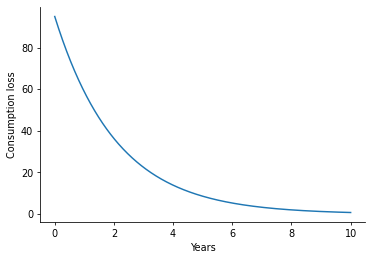

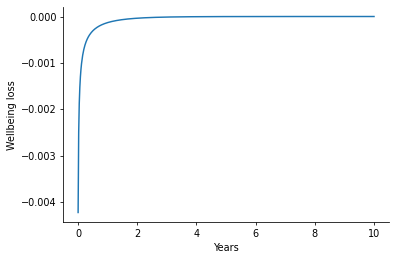

In [21]:
df = generate_households(num_households=1, exp=5000, v=0.3, fix_seed=False)

default_parameters = {'recovery_rate': 0.5, 
                      'years_to_recover': 10, 
                      'income_and_expenditure_growth': 0.02,
                      'average_productivity': 0.35,
                      'consumption_utility': 1.5,
                      'discount_rate': 0.04}

consumption, consumption_unaffected, consumption_loss, consumption_loss_npv, wellbeing = calculate_consumption_recovery(df, default_parameters, print_statistics=True)

ax = consumption_loss.T.plot(legend=False)
plt.xlabel('Years')
plt.ylabel('Consumption loss');
sns.despine()

ax = wellbeing.T.plot(legend=False)
plt.xlabel('Years')
plt.ylabel('Wellbeing loss');
sns.despine()

In [22]:
consumption_utility = 1.5
discount_rate = 0.04
weighted_average_expenditure = df['exp'].values[0]
total_wellbeing_loss = wellbeing.replace([np.inf, -np.inf], np.nan).dropna(axis=1).sum(axis=1).values[0]
total_asset_damage = df['keff'].multiply(df['v']).values[0]
total_consumption_loss = consumption_loss.sum(axis=1).values[0]
total_consumption_loss_npv = consumption_loss_npv.sum(axis=1).values[0]
weighted_average_expenditure, total_wellbeing_loss, total_asset_damage, total_consumption_loss_npv

(5000, -0.034520709496898866, 6032.746643707037, 9464.387539258825)

In [45]:
welfare = math.pow(weighted_average_expenditure, -consumption_utility)
welfare

2.82842712474619e-06

In [42]:
welfare = (math.pow(weighted_average_expenditure, 1 - consumption_utility)) / (1 - consumption_utility)
welfare

-0.0282842712474619

In [39]:
welfare = (math.pow((1 / discount_rate) * weighted_average_expenditure, 1 - consumption_utility) - 1) / (1 - consumption_utility)
welfare

1.9943431457505076

In [47]:
tot_consum_equiv_loss = - (total_wellbeing_loss / welfare)
tot_consum_equiv_loss

12204.91388831402

In [48]:
total_asset_damage / total_consumption_loss_npv, total_asset_damage / tot_consum_equiv_loss

(0.6374154290156501, 0.49428834147558226)